# Art painting classifier - Van Goth, Picasso, Dali

In [172]:
from fastai.vision import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline


# Download images

I have search for paintings of Van Gogh, Dali and Picasso on Google, I scrapped the URLs in a CSV format by typing Cmd-Opt-j on macOS and entering the following command in the console (Make sure AdBlock is paused).

`urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

# Create folders

I order to create the folders that contain all the images based on the URLs, follow the following steps:

- **Step 1**: Run only Cell 1, then Cell 4-5-6
- **Step 2**: Run only Cell 2, then Cell 4-5-6
- **Step 3**: Run only Cell 3, then Cell 4-5-6
- **Step 4**: Run Cell 7 to remove images that can't be openned


Cell 1

In [4]:
folder = 'van_gogh'
file = 'van_gogh.csv'

Cell 2

In [5]:
folder = 'dali'
file = 'dali.csv'

Cell 3

In [6]:
folder = 'picasso'
file = 'picasso.csv'

Cell 4

In [7]:
path = Path('data/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Cell 5

In [8]:
path.ls()

[PosixPath('data/.DS_Store'),
 PosixPath('data/picasso'),
 PosixPath('data/van_gogh'),
 PosixPath('data/picasso.csv'),
 PosixPath('data/models'),
 PosixPath('data/dali.csv'),
 PosixPath('data/van_gogh.csv'),
 PosixPath('data/dali')]

Cell 6

In [173]:
download_images(path/file, dest, max_pics=200)

Cell 7

In [10]:
classes = ['van_gogh','dali','picasso']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# View Data

In [174]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=tfms, size=112, num_workers=4).normalize(imagenet_stats)

In [175]:
data.classes

['dali', 'picasso', 'van_gogh']

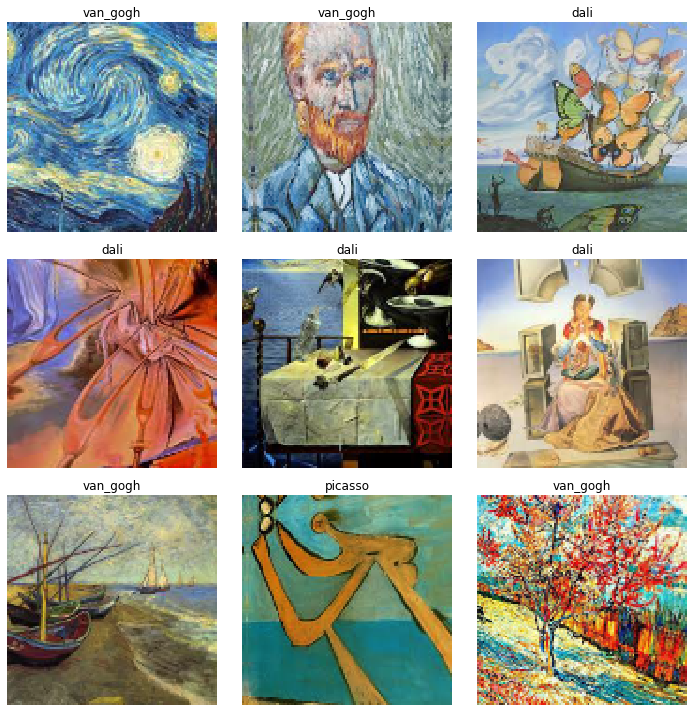

In [176]:
data.show_batch(rows=3, figsize=(10,10))

In [177]:
len(data.train_ds), len(data.valid_ds)

(145, 36)

# Clean up
Let's clean up all the images that are **not** paintings.

In [178]:
from fastai.widgets import *

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=112)
                   .databunch()
     )

In [179]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [180]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [181]:
ds, idxs = DatasetFormatter().from_similars(learn)

Getting activations...


Computing similarities...


In [182]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Train with Resnet
We will use a **convolutional neural network** where the model will take images as input and will output the **predicted probability** for eath of the categories *Van Gogh*, *Picasso* or *Dali*

In [183]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [159]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.116739,1.455989,0.555556,00:15
1,1.575244,1.010107,0.638889,00:15
2,1.325508,0.646743,0.777778,00:13


# Let's fine tune our model
To do so, we will optimise our **learning rate**

In [184]:
learn.unfreeze()

The Suggested LR (Learning Rate) is where the **gardient is the steepest** on the graph. I have first assigned a wide range of learning rates between (1e-9,1). It gives us a first guess for our LR.

In [161]:
learn.lr_find(1e-9,1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


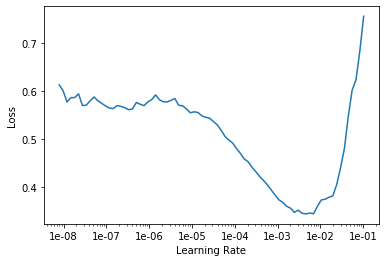

In [162]:
learn.recorder.plot()

# Result
Our Van Gogh-Picasso-Dali classifier is working correctly with 91.6667% accuracy.

In [185]:
learn.fit_one_cycle(30, max_lr=slice(7e-5,5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.871731,2.419085,0.333333,00:14
1,1.718893,1.833872,0.388889,00:15
2,1.454125,1.508277,0.527778,00:14
3,1.183767,1.159709,0.611111,00:14
4,0.978784,0.551703,0.750000,00:15
5,0.849056,0.305436,0.888889,00:15
6,0.724260,0.297988,0.944444,00:14
7,0.631828,0.205398,0.944444,00:14
8,0.553777,0.449757,0.916667,00:14
9,0.498957,0.670542,0.888889,00:14


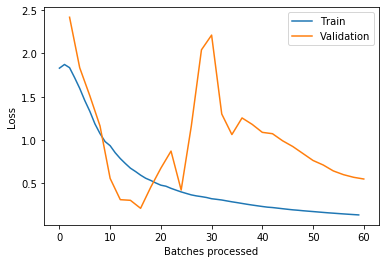

In [186]:
learn.recorder.plot_losses()

In [187]:
interp = ClassificationInterpretation.from_learner(learn)

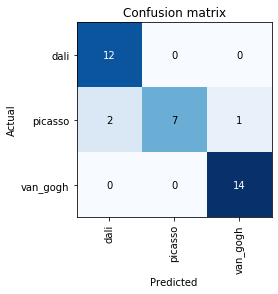

In [188]:
interp.plot_confusion_matrix()

In [189]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

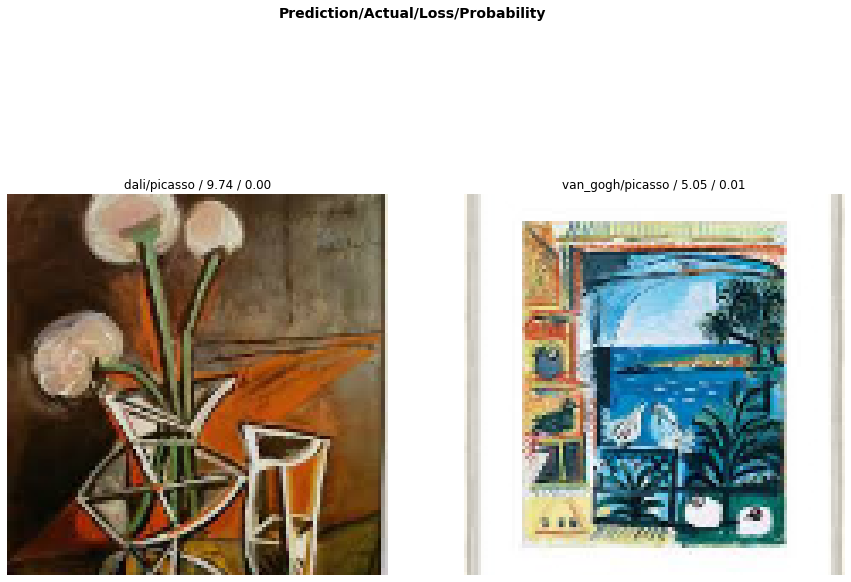

In [190]:
interp.plot_top_losses(2, figsize=(15,11))

In [191]:
learn.save('learner_7e-5')

# Predict

In [195]:
from PIL import Image
path_pred = path = Path('pred/')
path_pred.mkdir(parents=True, exist_ok=True)

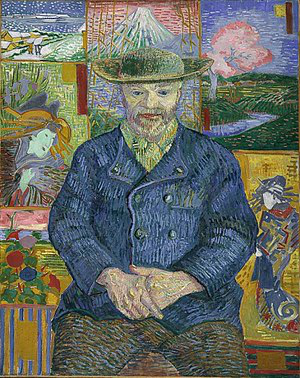

In [197]:
img = open_image(path_pred/"300px-Van_Gogh_-_Portrait_of_Pere_Tanguy_1887-8.jpeg")
img

In [201]:
learn = learn.load('learner_7e-5');

In [202]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, outputs

(Category van_gogh, tensor([1.0235e-09, 1.3971e-06, 1.0000e+00]))

**Right category! :)**